In [ ]:
!pip install gensim
!pip install tqdm
!pip install nltk
!pip install transformers
!pip install -U "ray[tune]"
!pip install sklearn
!pip install optuna
!pip install --user fastai
!pip install imblearn

In [72]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

import gensim.downloader as api
from tqdm import tqdm
from nltk import word_tokenize
import torch
import multiprocessing

from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, DistilBertForSequenceClassification
from imblearn.over_sampling import SMOTE # Handling Imbalanced

import sys

sys.path.insert(0, '/home/jupyter/src/natalies-little-helper/util')
import helpers as helper

In [52]:
# Number of CPU cores available
cpu = multiprocessing.cpu_count()

# Set up cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of GPUs being used
gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0

# CPU and GPU Resources
proc_resources = {'cpu': cpu, 'gpu': gpu}

In [53]:
data_path = "/home/jupyter/src/natalies-little-helper/data/"

intent = pd.read_csv(data_path + "intent_Tweets.csv", index_col=0)

intentSubGroups = {
    'Customer Service Issue': 'Customer Service Issue',
    'Late Flight': 'Late Flight',
    'Cancelled Flight': 'Cancelled Flight',
    'Lost Luggage': 'Luggage',
    'Bad Flight': 'Bad Flight',
    'Flight Booking Problems': 'Flight Booking Problems',
    'Flight Attendant Complaints': 'Flight Attendant Complaints',
    'longlines': 'Customer Service Issue',
    'Damaged Luggage': 'Luggage',
    'Can\'t Tell': 'Can\'t Tell'
}

intent['negativereason'] = intent.negativereason.apply(lambda x: intentSubGroups[x])

# yLabels = intent.negativereason.astype('category').cat.categories
print("Number of Negative Reasons: ", intent.negativereason.count())
intent.negativereason.value_counts()

Number of Negative Reasons:  9178


Customer Service Issue         3088
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Luggage                         798
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
Name: negativereason, dtype: int64

In [54]:
intent = intent[intent['text'].notna()]
intent = intent[intent['negativereason'].notna()]
intent.reset_index(drop=True, inplace=True)
num_labels = len(intent.negativereason.unique())

rmap = {reason: i for i, reason in enumerate(intent.negativereason.unique())}
imap = {i: reason for reason, i in rmap.items()}

yLabels = [imap[i] for i in range(len(imap))]

intent.negativereason = intent.negativereason.apply(lambda x: rmap[x])

## Select Samples

In [55]:
intent.intentGroup.value_counts()

Customer Service    4098
Flights             3092
Can't Tell          1190
Luggage              798
Name: intentGroup, dtype: int64

In [56]:
N_SAMPLES = 798
intent_groups_df = intent.groupby('intentGroup').apply(lambda x: x.sample(n=N_SAMPLES)).reset_index(drop=True)
intent_group_labels = intent.intentGroup.astype('category').cat.categories
intent_group_map = {group: i for i, group in enumerate(intent_group_labels)}
intent_groups_df.intentGroup = intent_groups_df.intentGroup.apply(lambda x: intent_group_map[x])

In [57]:
intent_groups_df.intentGroup.value_counts()

0    798
1    798
2    798
3    798
Name: intentGroup, dtype: int64

## Split Train and Test Data

In [58]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(intent.text)
y = intent['negativereason']

# For imbalanced data
smote = SMOTE()
x_sm,y_sm = smote.fit_resample(X,y)

scaler = StandardScaler(with_mean=False)
scaler.fit(x_sm)

xTrain, xTest, yTrain, yTest = train_test_split(x_sm, y_sm, train_size=0.8, stratify=y_sm)

In [59]:
XGroup = vectorizer.fit_transform(intent_groups_df.text)
yGroup = intent_groups_df.intentGroup

smote = SMOTE()
xGroup_sm, yGroup_sm = smote.fit_resample(XGroup,yGroup)

scalerGroup = StandardScaler(with_mean=False)
scalerGroup.fit(xGroup_sm)

xGroupTrain, xGroupTest, yGroupTrain, yGroupTest = train_test_split(xGroup_sm, yGroup_sm, train_size=0.8, stratify=yGroup_sm)

# Base Classifiers

## Perceptron

### Intent Reasons

In [60]:
clf = OneVsRestClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
clf.fit(scaler.transform(xTrain), yTrain)
# clf.fit(xTrain, yTrain)

# yPred = clf.predict(xTest)

# precisions = precision_score(yTest, yPred, average=None)
# recalls = recall_score(yTest, yPred, average=None)
# f1s = f1_score(yTest, yPred, average=None)

# helper.evaluate_score(yTest, yPred)

OneVsRestClassifier(estimator=Perceptron(n_jobs=-1), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       618
           1       0.81      0.73      0.77       618
           2       0.65      0.87      0.74       618
           3       0.64      0.59      0.61       617
           4       0.94      0.75      0.83       617
           5       0.82      0.95      0.88       618
           6       0.94      0.77      0.85       618
           7       0.85      0.94      0.89       617

    accuracy                           0.81      4941
   macro avg       0.82      0.81      0.81      4941
weighted avg       0.82      0.81      0.81      4941



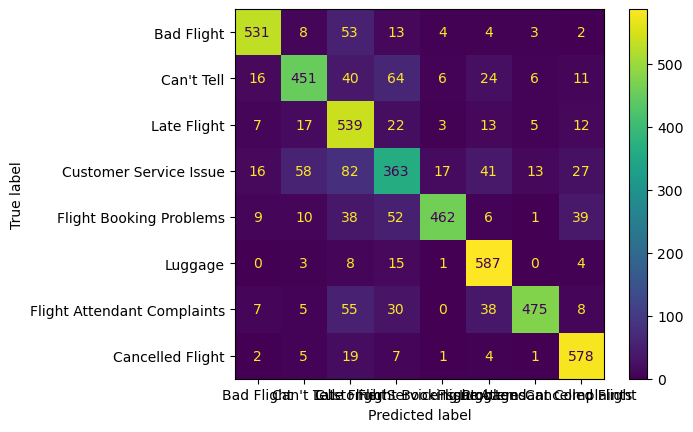

array([1, 2, 0, ..., 0, 2, 2])

In [61]:
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [62]:
clf = OneVsRestClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
clf.fit(scalerGroup.transform(xGroupTrain), yGroupTrain)

OneVsRestClassifier(estimator=Perceptron(n_jobs=-1), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.54      0.53      0.53       160
           1       0.61      0.52      0.56       160
           2       0.67      0.70      0.69       160
           3       0.70      0.81      0.75       159

    accuracy                           0.64       639
   macro avg       0.63      0.64      0.63       639
weighted avg       0.63      0.64      0.63       639



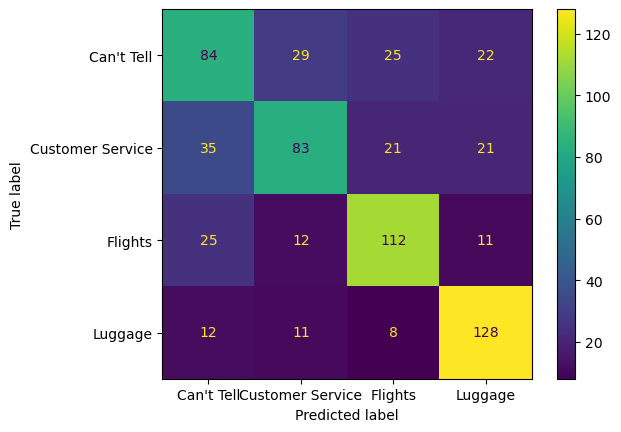

In [63]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

## Logistic Regression

### Intent Reasons

In [64]:
clf = LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)
clf.fit(xTrain, yTrain)

yPred = clf.predict(xTest)

helper.evaluate_score(yTest, yPred)

Accuracy:	 0.914187411455171
Precision:	 [0.94453005 0.84107946 0.89368771 0.8340708  0.91981846 0.95741325
 0.94486983 0.95666132]
Recall: 	 [0.99190939 0.90776699 0.87055016 0.61102107 0.98541329 0.98220065
 0.99838188 0.96596434]
F1 scores:	 [0.96764009 0.87315175 0.88196721 0.70533209 0.9514867  0.96964856
 0.97088906 0.96129032]
Average
	Precision: 0.9115212150698905
	Recall: 0.914187411455171
	F1: 0.910198476017303


4941
4941
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7}
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       618
           1       0.84      0.91      0.87       618
           2       0.89      0.87      0.88       618
           3       0.83      0.61      0.71       617
           4       0.92      0.99      0.95       617
           5       0.96      0.98      0.97       618
           6       0.94      1.00      0.97       618
           7       0.96      0.97      0.96       617

    accuracy                           0.91      4941
   macro avg       0.91      0.91      0.91      4941
weighted avg       0.91      0.91      0.91      4941



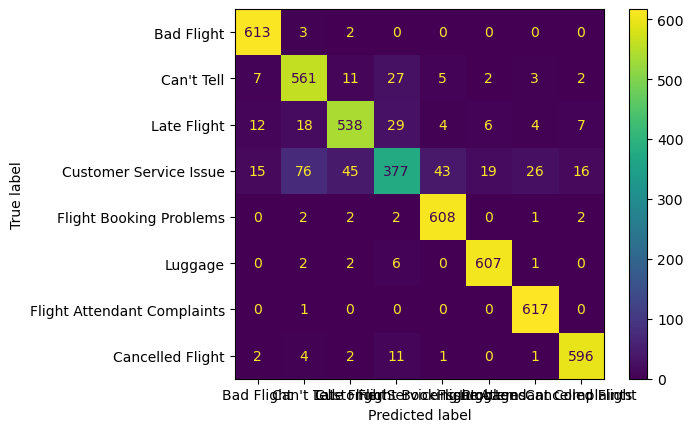

array([1, 3, 0, ..., 0, 1, 2])

In [65]:
print(len(yPred))
print(len(yTest))
ySet = {y for y in yPred}
yTSet = {y for y in yTest}
print(ySet)
print(yTSet)
# helper.evaluate_score([0,1,2,3,4], [1,2,0,3,3])
# helper.evaluate_score(yTest, yPred)
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [66]:
clf = LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)
clf.fit(xGroupTrain, yGroupTrain)

LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.53      0.60      0.56       160
           1       0.59      0.59      0.59       160
           2       0.69      0.66      0.67       160
           3       0.78      0.73      0.76       159

    accuracy                           0.64       639
   macro avg       0.65      0.64      0.65       639
weighted avg       0.65      0.64      0.65       639



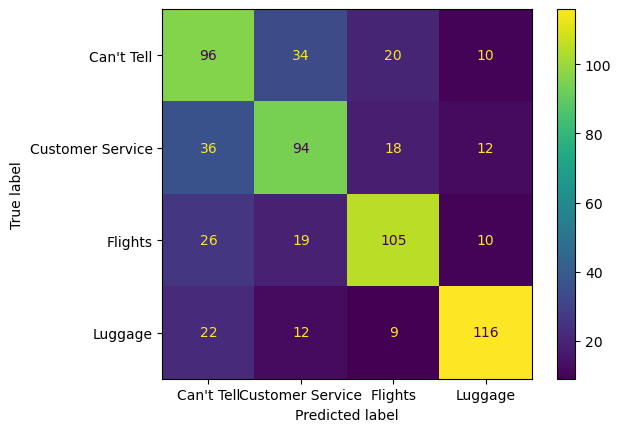

In [67]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

## SVC

### Intent Reasons

In [68]:
clf = LinearSVC()
clf.fit(xTrain, yTrain)

# yPred = clf.predict(xTest)

# helper.evaluate_score(yTest, yPred)

LinearSVC()

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       618
           1       0.83      0.88      0.85       618
           2       0.88      0.85      0.87       618
           3       0.84      0.59      0.69       617
           4       0.90      0.98      0.94       617
           5       0.95      0.98      0.97       618
           6       0.92      0.99      0.96       618
           7       0.95      0.96      0.95       617

    accuracy                           0.90      4941
   macro avg       0.90      0.90      0.90      4941
weighted avg       0.90      0.90      0.90      4941



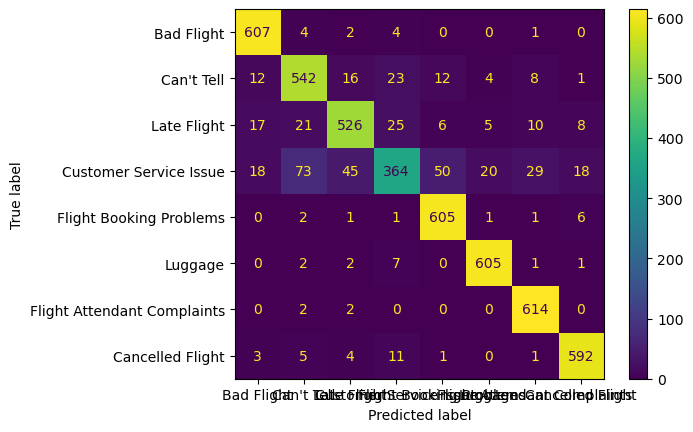

array([1, 6, 3, ..., 0, 2, 2])

In [69]:
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [70]:
clf = LinearSVC()
clf.fit(xGroupTrain, yGroupTrain)

LinearSVC()

              precision    recall  f1-score   support

           0       0.53      0.54      0.54       160
           1       0.58      0.59      0.59       160
           2       0.68      0.64      0.66       160
           3       0.77      0.78      0.77       159

    accuracy                           0.64       639
   macro avg       0.64      0.64      0.64       639
weighted avg       0.64      0.64      0.64       639



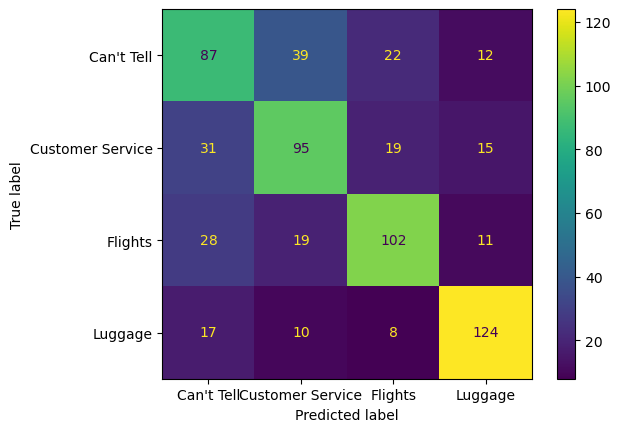

In [71]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

# Advance Models

In [33]:
from fastai.text.all import *
from fastai import *

In [34]:
# data_lm = (TextList
#            .from_csv(path, data_path + 'Tweets.csv', cols='text')
#            #Where are the text? Column 'text' of tweets.csv
#            .split_by_rand_pct(0.2)
#            #How to split it? Randomly with the default 20% in valid
#            .label_for_lm()
#            #Label it for a language model
#            .databunch(bs=48))
#            #Finally we convert to a DataBunch
# data_lm.show_batch()

train= pd.read_csv(data_path + 'Tweets.csv')

data_lm = DataBlock(
        blocks=TextBlock.from_df('text', is_lm=True),
        get_x=ColReader('text'),
        splitter=RandomSplitter(0.2)
)

data_lm = data_lm.dataloaders(train, bs=10, seq_len=72, device=torch.device('cuda'))
data_lm.show_batch()

,text,text_
0,xxbos @americanair 2nd time in 4 days that my flight has been delayed and my gate agent has n't said anything ! xxmaj thanks for the memories . # neveragain xxbos @united now let there also pls be in - flight live xxup tv on xxup xxunk xxup den - ewr so i can watch the # xxmaj oscars ? ? xxbos @united xxunk @ntrustopen i read that last hashtag as xxmaj,@americanair 2nd time in 4 days that my flight has been delayed and my gate agent has n't said anything ! xxmaj thanks for the memories . # neveragain xxbos @united now let there also pls be in - flight live xxup tv on xxup xxunk xxup den - ewr so i can watch the # xxmaj oscars ? ? xxbos @united xxunk @ntrustopen i read that last hashtag as xxmaj go
1,"hook me up for # destinationdragons xxbos @americanair xxmaj these birds could fly to xxmaj south xxmaj america for example # xxmaj argentina xxbos @southwestair this is ridiculous . xxmaj it 's been 2 hours on hold to rebook xxmaj cancelled xxmaj flightled flight . xxbos @usairways , xxmaj i 'm expecting 400 % reimbursement for the unprofessional decisions with xxup xxunk on 21 xxmaj feb . xxmaj check your very full","me up for # destinationdragons xxbos @americanair xxmaj these birds could fly to xxmaj south xxmaj america for example # xxmaj argentina xxbos @southwestair this is ridiculous . xxmaj it 's been 2 hours on hold to rebook xxmaj cancelled xxmaj flightled flight . xxbos @usairways , xxmaj i 'm expecting 400 % reimbursement for the unprofessional decisions with xxup xxunk on 21 xxmaj feb . xxmaj check your very full complaint"
2,"boys & & bags off . xxmaj xxunk ! ! xxbos @virginamerica xxmaj while other airlines were n't xxmaj cancelled xxmaj flighting flights into xxup bos , and helping their customers get home , xxmaj virgin was saying xxmaj good luck ! xxbos @usairways do you know what flight the pilots for xxunk are coming in on ? xxmaj thanks . xxbos @united xxup lhr arrival lounge # fail . xxmaj waited","& & bags off . xxmaj xxunk ! ! xxbos @virginamerica xxmaj while other airlines were n't xxmaj cancelled xxmaj flighting flights into xxup bos , and helping their customers get home , xxmaj virgin was saying xxmaj good luck ! xxbos @usairways do you know what flight the pilots for xxunk are coming in on ? xxmaj thanks . xxbos @united xxup lhr arrival lounge # fail . xxmaj waited 20"
3,"xxmaj that 's why i had to fly with you . # epicfail xxbos @united xxunk @ntrustopen ah , so that 's where the funds to fix the broken plane upon which i sat for 4 hrs on xxup iah runway went . xxbos @americanair xxmaj aww cool ! xxmaj it 's nice to know they are still up above my head then . xxmaj one of my xxunk . xxbos @southwestair","that 's why i had to fly with you . # epicfail xxbos @united xxunk @ntrustopen ah , so that 's where the funds to fix the broken plane upon which i sat for 4 hrs on xxup iah runway went . xxbos @americanair xxmaj aww cool ! xxmaj it 's nice to know they are still up above my head then . xxmaj one of my xxunk . xxbos @southwestair xxmaj"
4,"which she xxunk and helped make awesome ! xxbos @united hi guys , do you have a general enquires email address please ? xxmaj thanks xxmaj david . xxbos @united that 's xxunk with an overnight xxmaj miami . xxbos @usairways xxup ha ! xxmaj you 're fun . xxbos @usairways is there a phone number or email address to customer service ? xxbos @united xxmaj thanks for taking care of that","she xxunk and helped make awesome ! xxbos @united hi guys , do you have a general enquires email address please ? xxmaj thanks xxmaj david . xxbos @united that 's xxunk with an overnight xxmaj miami . xxbos @usairways xxup ha ! xxmaj you 're fun . xxbos @usairways is there a phone number or email address to customer service ? xxbos @united xxmaj thanks for taking care of that xxup"
5,'m told to call xxmaj late xxmaj flightr . xxmaj please help me here . xxbos @usairways i do nt need to check status of my flight because i was xxup on the plane and you had a door malfunctio

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
# learn.model = learn.cuda()
# #find the optimal learning rate & visualize it
learn.lr_find();
learn.recorder.plot();

In [ ]:
learn.fit_one_cycle(6,5e-2, moms=(0.85,0.75))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

# Distilbert Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", Truncation=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

In [ ]:
data_og = pd.concat([intent.text, intent.negativereason], axis=1)

data = []
for t in data_og.iterrows():
    temp = {}
    temp["text"] = t[1].text
    temp["label"] = t[1].negativereason
    temp.update(tokenizer(t[1].text))
    data.append(temp)

train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [ ]:
def model_init():
    return DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels, force_download=True, cache_dir="/home/jupyter/cache/")

training_args = TrainingArguments(
    output_dir="./intent_results",
    learning_rate=2e-5,
    evaluation_strategy = "steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=100,
    eval_steps=100
)

trainer_tuned = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
best_run = trainer_tuned.hyperparameter_search(n_trials=1, direction="maximize")

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer_tuned.args, n, v)

trainer_tuned.train()

In [ ]:
preds = trainer_tuned.predict(test_dict)

In [ ]:
yTrue = [t["label"] for t in test_dict]
yPred = [p.argmax() for p in preds[0]]
helper.evaluate_score(yTrue, yPred)